In [13]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import os
import numpy as np

import __init_path__
import env

from slam.models.relocalization.bovw import BoVW
from slam.utils import resize_image


font = {'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)


csv_path = '/home/d-zhukov/Projects/odometry_git/experiments/kitti_4_6/relocaliztion_19/predictions/00.csv'
dataset_root = '/datasets/odometry/KITTI_odometry_2012/'

In [14]:
df = pd.read_csv(csv_path)
df.head()

,euler_x,euler_x_confidence,euler_y,euler_y_confidence,euler_z,euler_z_confidence,from_db_index,from_index,t_x,t_x_confidence,t_y,t_y_confidence,t_z,t_z_confidence,to_db_index,to_index,to_path,from_path
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,00/rgb/1.png,00/rgb/0.png
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,00/rgb/2.png,00/rgb/1.png
2,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.0,00/rgb/2.png,00/rgb/0.png
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,00/rgb/3.png,00/rgb/2.png
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,00/rgb/4.png,00/rgb/3.png


In [15]:
def visualize_with_kp(df, only_loops, difference_threshold):
    frame_total = df.to_index.iloc[-1]
    frame_counter = 1
    
    exctractor = cv2.xfeatures2d.SIFT_create()
    matcher = cv2.BFMatcher()
    
    while frame_counter <=  frame_total:  
        matches = df[df['to_index'] == frame_counter]
        frame_counter += 1
        
        if len(matches) > 0:
            
            if only_loops:
                max_difference = 0
                for k in range(len(matches)):
                    difference = matches['to_index'].iloc[k] - matches['from_index'].iloc[k]
                    if difference > max_difference:
                        max_difference = difference
                
                if max_difference < difference_threshold:
                    continue
            
            print(matches[['to_index', 'from_index']])
            
            image1 = cv2.imread(os.path.join(dataset_root, matches.to_path.iloc[0]))
            image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
            height, width, channels_num = image1.shape
            small_height = height // 4
            small_width = width // 4
            image1 = resize_image(image1, (small_width, small_height))
            kp1, des1 = exctractor.detectAndCompute(np.uint8(image1), None)
            
            for k in range(3):
                if k < len(matches):
                    image2 = cv2.imread(os.path.join(dataset_root, matches.from_path.iloc[k]))
                    image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)
                else:
                    image2 = np.zeros_like(image1)
                height, width, channels_num = image2.shape
                small_height = height // 4
                small_width = width // 4
                image2 = resize_image(image2, (small_width, small_height))
                kp2, des2 = exctractor.detectAndCompute(np.uint8(image2), None)
                if des1 is None or des2 is None:
                    continue
                
                bf_matches = matcher.knnMatch(des1, des2, 2)
                bf_matches = BoVW.ratio_test(bf_matches)
                print('Number of matches', len(bf_matches))
                bf_matches = [match[0] for match in bf_matches]
                image3 = cv2.drawMatches(image1, kp1, image2, kp2, bf_matches, None)
                plt.figure(figsize=(40, 20))
                plt.imshow(image3)
                plt.title(f'from {matches.from_index.iloc[k]} to {matches.to_index.iloc[k]}')
                plt.show()

In [16]:
def visualize(df, only_loops, difference_threshold):
    frame_total = df.to_index.iloc[-1]
    frame_counter = 1
    
    while frame_counter <=  frame_total:  
        matches = df[df['to_index'] == frame_counter]
        frame_counter += 1
        
        if len(matches) > 0:
            
            if only_loops:
                max_difference = 0
                for k in range(len(matches)):
                    difference = matches['to_index'].iloc[k] - matches['from_index'].iloc[k]
                    if difference > max_difference:
                        max_difference = difference
                
                if max_difference < difference_threshold:
                    continue
            
            print(matches[['to_index', 'from_index']])
            
            image = cv2.imread(os.path.join(dataset_root, matches.to_path.iloc[0]))
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            height, width, channels_num = image.shape
            small_height = height // 4
            small_width = width // 4
            image = resize_image(image, (small_width, small_height))
            fig, axes = plt.subplots(2, 2, figsize=(40, 10))
            axes[0][0].title.set_text(f'to {matches.to_index.iloc[0]}')
            axes[0][0].imshow(image / 255)
            for k in range(3):
                if k < len(matches):
                    image = cv2.imread(os.path.join(dataset_root, matches.from_path.iloc[k]))
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    height, width, channels_num = image.shape
                    small_height = height // 4
                    small_width = width // 4
                    image = resize_image(image, (small_width, small_height))
                    axes[(k + 1) // 2][(k + 1) % 2].title.set_text(f'from {matches.from_index.iloc[k]}')
                else:
                    image = np.zeros_like(image)
                    axes[(k + 1) // 2][(k + 1) % 2].title.set_text(f'No match')
                axes[(k + 1) // 2][(k + 1) % 2].imshow(image / 255)
            plt.show()

      to_index  from_index
3411    1572.0      1570.0
3412    1572.0       128.0


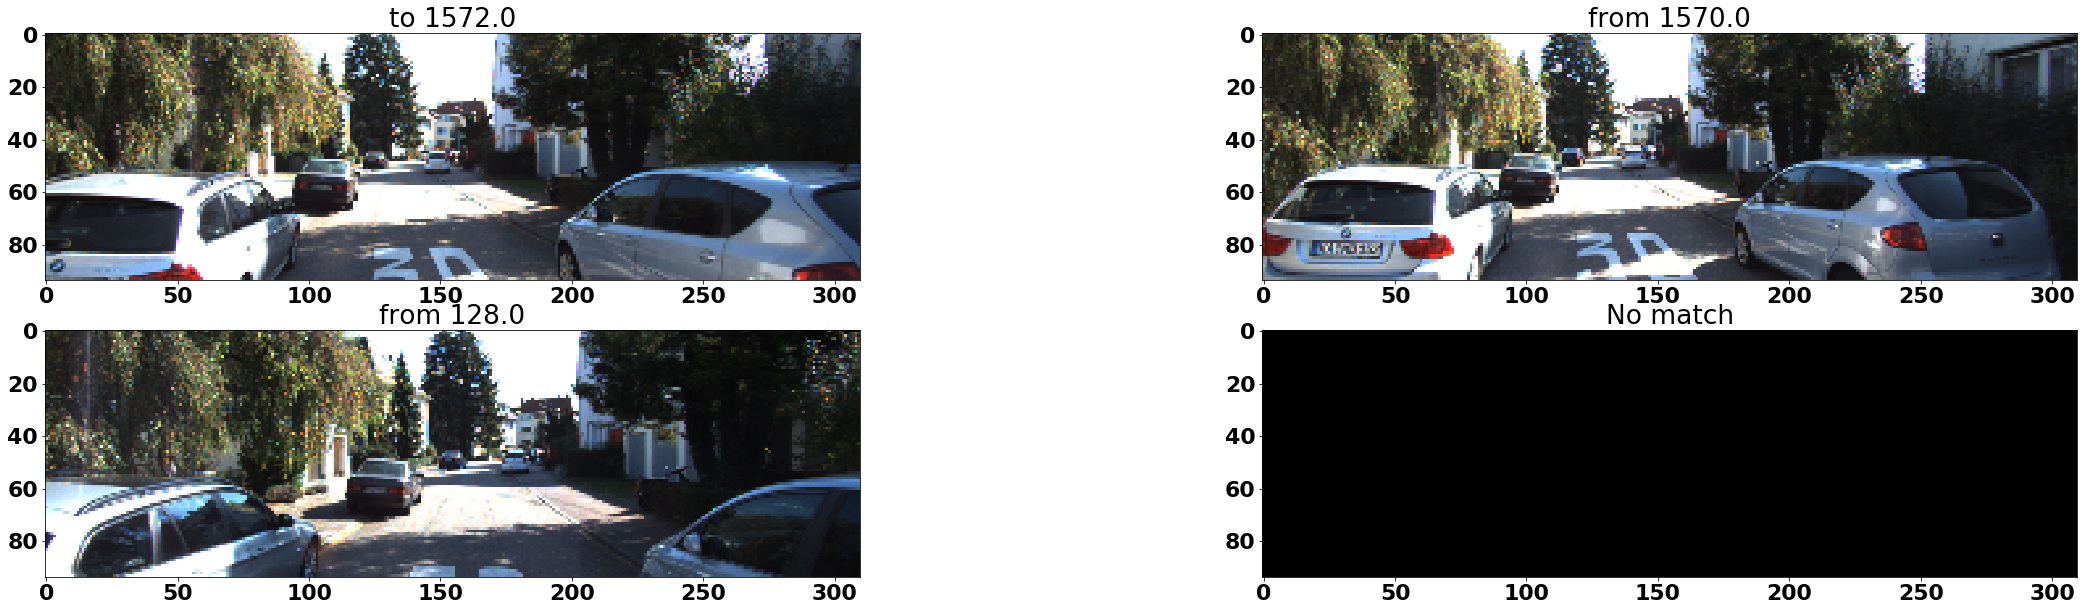

      to_index  from_index
3415    1574.0       132.0


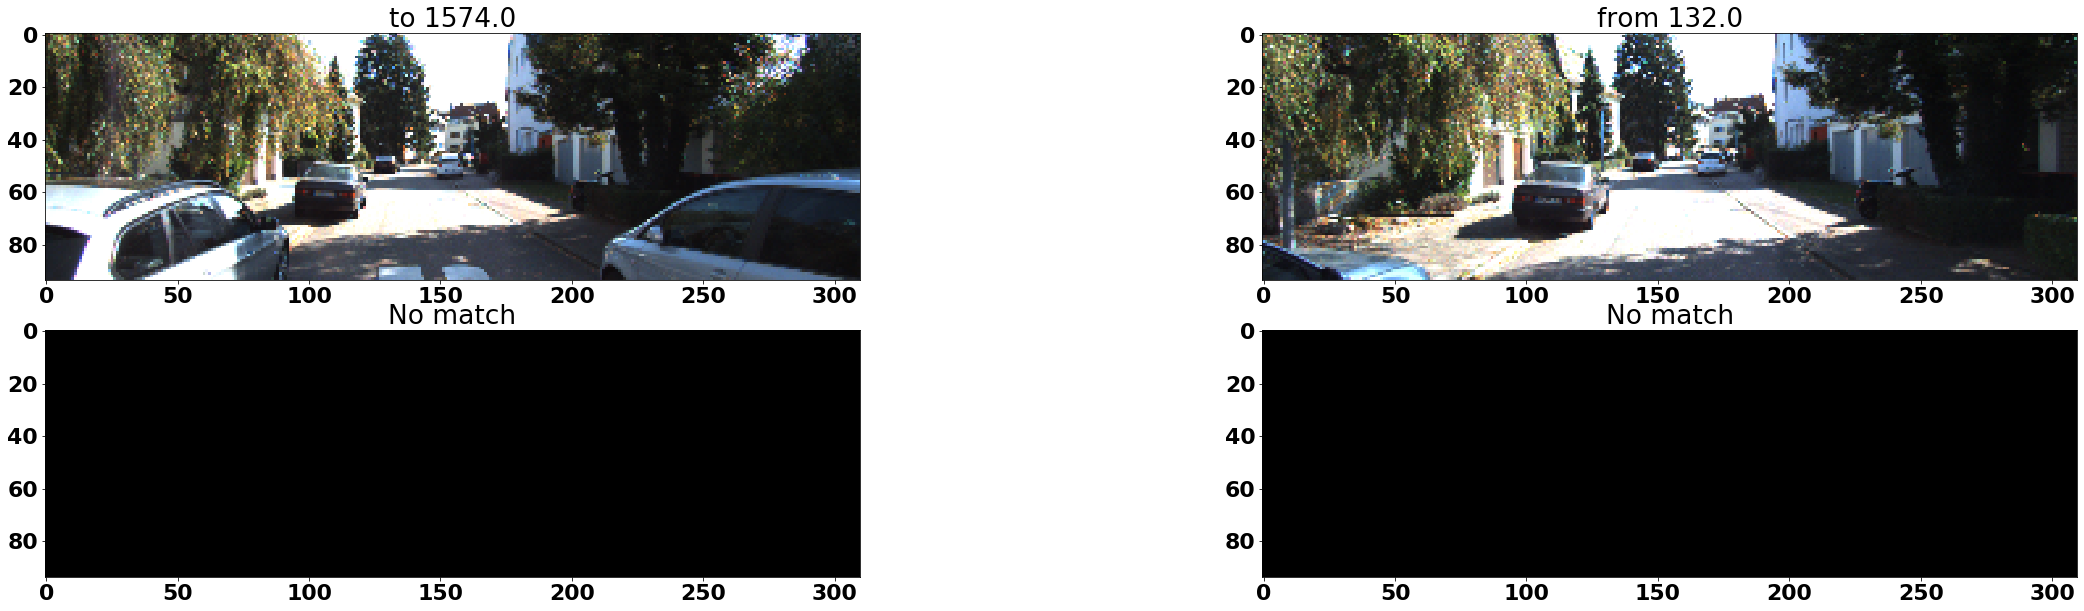

      to_index  from_index
3418    1576.0      1574.0
3419    1576.0       132.0
3420    1576.0       130.0
3421    1576.0       128.0
3422    1576.0       134.0
3423    1576.0       126.0


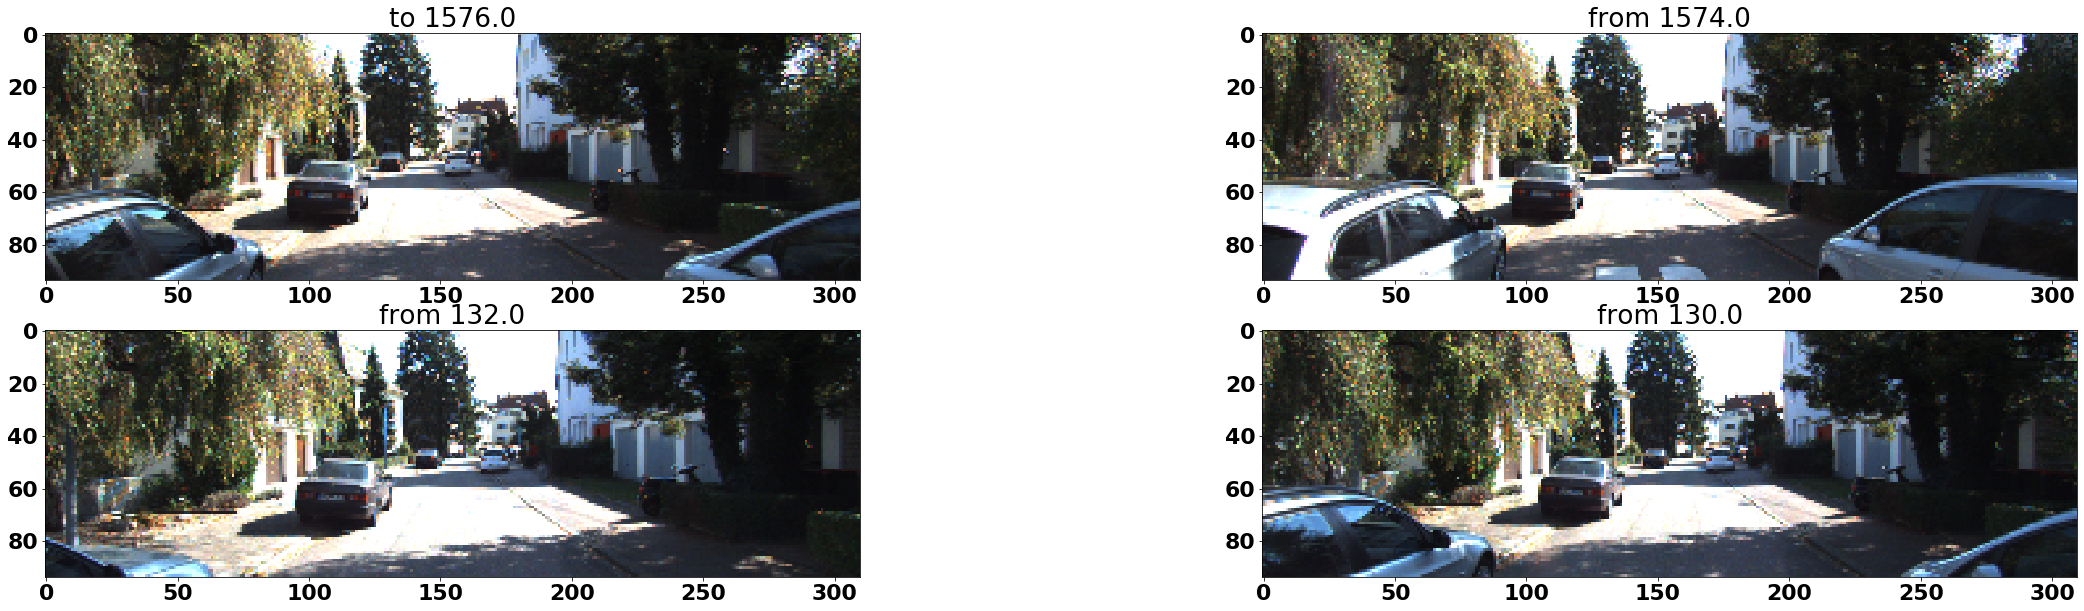

      to_index  from_index
3426    1578.0       132.0
3427    1578.0       134.0
3428    1578.0      1576.0
3429    1578.0       130.0
3430    1578.0       128.0
3431    1578.0      1574.0
3432    1578.0       136.0
3433    1578.0       138.0


In [ ]:
is_keyframe = ~np.isnan(df['to_db_index'])
df = df[is_keyframe]

visualize(df, only_loops=True, difference_threshold=100)